In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

sns.set_theme()
sns.set_style("white")
sns.set_context('notebook')

%config InlineBackend.figure_format = 'png'

# Data Wrangling 

In [2]:
def analyte_format(s:str) -> str:
    """Format the analyte name"""
    if '(' in s and ')' in s:
        start = s.find('(')
        end = s.find(')')
        return s[:start].title() + s[start:end+1]
    elif s == "PFOS-PFOA":
        return s
    else:
        return s.title()

#load the data
df_pfas_samples = (
    pd
    .read_csv('PFAS_Sampling_Results.csv')
    [['PWSID', 'ANALYTE', 'SAMPLE_RESULT']]
    .rename(columns={'PWSID': 'pws_id',
                     'ANALYTE': 'analyte',
                     'SAMPLE_RESULT': 'sample_result'})
    .assign(sample_result = lambda x: x.sample_result.str.replace("<", ""),
            analyte = lambda x: x.analyte.apply(analyte_format))
    .astype({'pws_id': 'str',
             'analyte': 'category',
             'sample_result': 'float64'})
    )

df_pws = (
    pd
    .read_excel('PWS.xls', sheet_name='PWS-07-25-2023')
    [['PWS ID', 'PWS NAME', 'CITY', 'STATE', 'ZIP CODE']]
    .rename(columns={'PWS ID': 'pws_id',
                     'PWS NAME': 'pws_name',
                     'CITY': 'city',
                     'STATE': 'state',
                     'ZIP CODE': 'zip_code'})
    .assign(city = lambda x: x.city.str.title(),
            pws_name = lambda x: x.pws_name.str.title())
    .where(lambda x: x.state == 'OH')
    )

# join the tables
df_merged = (
    df_pfas_samples
    .merge(df_pws, left_on='pws_id', right_on='pws_id', how='left')
    .dropna(subset=['state', 'city', 'pws_name'])
    [['pws_id', 'pws_name', 'analyte', 'sample_result', 'city', 'zip_code']]
    )

df_merged.info()
df_merged.sample(5)

<class 'pandas.core.frame.DataFrame'>
Index: 21342 entries, 0 to 23417
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   pws_id         21342 non-null  object  
 1   pws_name       21342 non-null  object  
 2   analyte        21342 non-null  category
 3   sample_result  21342 non-null  float64 
 4   city           21342 non-null  object  
 5   zip_code       21342 non-null  object  
dtypes: category(1), float64(1), object(4)
memory usage: 1021.6+ KB


,pws_id,pws_name,analyte,sample_result,city,zip_code
7371,OH3239812,Riverdale Local Schools,Perfluorononanoic Acid (PFNA),1.8,Mt Blanchard,45867
9590,OH4302212,Stewart Lodge,Perfluoroctanoic Acid (PFOA),5.0,Warren,44483
19628,OH8301112,Otterbein-Lebanon Retreat Center,Perfluoroctane Sulfonic Acid (PFOS),5.0,Lebanon,45036
18719,OH7835212,Bloomfield High School,Perfluorobutanesulfonic Acid (PFBS),4.6,N. Bloomfield,44450
12191,OH5300012,Leading Creek Conservancy District,Perfluorobutanesulfonic Acid (PFBS),5.0,Rutland,45775


# Zip Code Hotspots for PFAS Detections

My assuption is that hot spots are how frequent a zip code is sampled.

In [3]:
zip_code_samples = df_merged.groupby('zip_code').size()

zip_code_describe = (
    zip_code_samples
    .reset_index(name='n_samples')
    .sort_values('n_samples', ascending=False)
    .describe())

zip_code_describe

,n_samples
count,711.000000
mean,30.016878
std,46.522686
min,6.000000
25%,12.000000
50%,12.000000
75%,30.000000
max,540.000000


In [4]:
zip_code_samples = (
    zip_code_samples
    .reset_index(name='n_samples')
    .sort_values('n_samples', ascending=False)
    )

zip_code_samples

,zip_code,n_samples
388,44647,540
239,44023,510
590,45433,492
414,44691,354
391,44654,288
...,...,...
97,43344,6
392,44654-0029,6
396,44660,6
400,44667-9500,6


In [5]:
# calculate a percentile
quantile = 0.90
quantile_percentage = int(quantile * 100)

threshold = zip_code_samples.n_samples.quantile(quantile)

print(f"{quantile_percentage}th percentile: {threshold}")

# filter for hotspots
hotspots = zip_code_samples[zip_code_samples.n_samples > threshold]

hotspots

90th percentile: 60.0


,zip_code,n_samples
388,44647,540
239,44023,510
590,45433,492
414,44691,354
391,44654,288
...,...,...
506,45150,66
248,44060,66
528,45308,66
259,44077,66


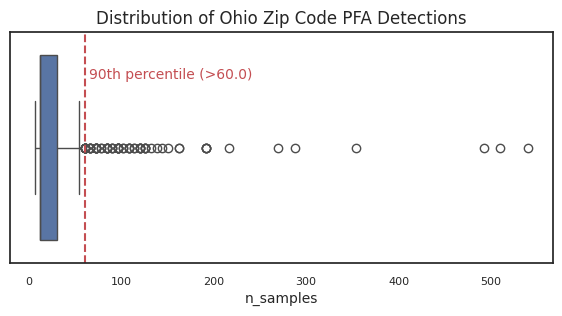

In [6]:
plt.figure(figsize=(7, 3))
sns.boxplot(x=zip_code_samples["n_samples"])
plt.axvline(x=threshold, color='r', linestyle='--')
plt.text(threshold+5, -0.3, f"{quantile_percentage}th percentile (>{threshold})", color='r', fontsize=10)
plt.title('Distribution of Ohio Zip Code PFA Detections', fontsize=12)
plt.xlabel('n_samples', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.show()

In [7]:
# hotspot data
df_hotspots = df_merged.loc[df_merged.zip_code.isin(hotspots.zip_code)]

df_hotspots

,pws_id,pws_name,analyte,sample_result,city,zip_code
222,OH0301512,Aqua Ohio - Southwood,Perfluorobutanesulfonic Acid (PFBS),5.0,Massillon,44647
223,OH0301512,Aqua Ohio - Southwood,Hexafluoropropylene Oxide Dimer Acid,25.0,Massillon,44647
224,OH0301512,Aqua Ohio - Southwood,Perfluoroctanoic Acid (PFOA),5.0,Massillon,44647
225,OH0301512,Aqua Ohio - Southwood,Perfluoroctane Sulfonic Acid (PFOS),5.0,Massillon,44647
226,OH0301512,Aqua Ohio - Southwood,Perfluorononanoic Acid (PFNA),5.0,Massillon,44647
...,...,...,...,...,...,...
23347,OH2876950,Chester Plaza,Perfluoroctanoic Acid (PFOA),5.0,Burton,44021
23348,OH2876950,Chester Plaza,Perfluoroctane Sulfonic Acid (PFOS),5.0,Burton,44021
23349,OH2876950,Chester Plaza,Perfluorononanoic Acid (PFNA),5.0,Burton,44021
23350,OH2876950,Chester Plaza,Perfluorohexane Sulfonic Acid (PFHXS),5.0,Burton,44021


# PFAS Fingerprint Matches: Wright-Patterson AFB

## Generate Cosine Similarity 

In [8]:
# 1. pivot table to create matrix of samples 
df_pivot = df_merged.pivot_table(index='pws_name', 
                                 columns='analyte', 
                                 values='sample_result', 
                                 observed=False)

# 2. standardize data (put all features on the same scale) x - mean(x) / std(x)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_pivot), columns=df_pivot.columns, index=df_pivot.index)

# 3. calculate cosine similarity
cosine_sim = cosine_similarity(df_scaled)

# 4. convert similarity matrix to df
df_similarity = pd.DataFrame(cosine_sim, columns=df_pivot.index, index=df_pivot.index)

df_similarity.shape

(1317, 1317)

## Convert Cosine Simialrity to Principle Component Analysis (PCA) & Apply K-Means Clustering

In [9]:
# 1. standardize data (put all features on the same scale) x - mean(x) / std(x)
standardized_data = scaler.fit_transform(df_similarity)

# 2. apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(standardized_data)

# 3. convert the transformed data back to DataFrame for visualization
df_pca = pd.DataFrame(principal_components, index=df_similarity.index, columns=['PC1', 'PC2'])

# 4. create a boolean mask for rows where 'pws_name' contains "Wright-Patterson"
wright_patterson_mask = df_pca.index.str.contains("Wright-Patterson")

# 5. apply K-means clustering, set random_state for consistancey
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(df_pca)

# 6. add cluster labels to the DataFrame to use for visualization
df_pca['Cluster'] = kmeans.labels_

## Generate PCA Scatter Plot with K-Means Clustering

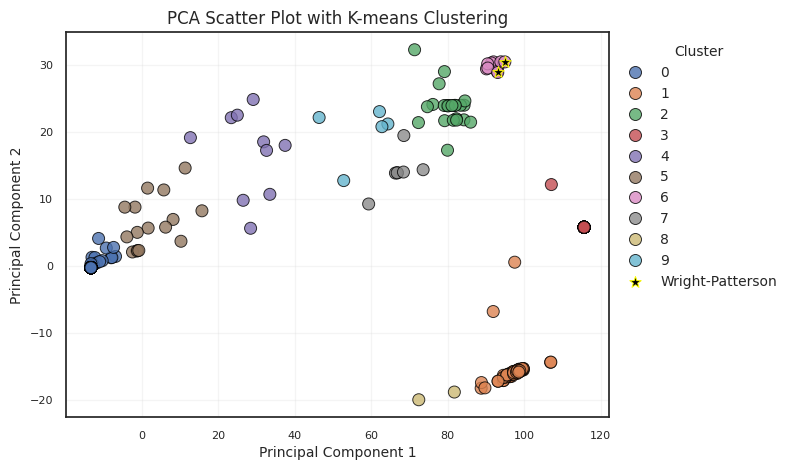

In [10]:
# plot the PCA scatter plot with K-means clustering
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_pca, 
                x='PC1',
                y='PC2', 
                hue='Cluster', 
                palette='deep', 
                marker='o', 
                edgecolor='black',
                s=75,
                alpha=0.8)

# add a star marker to the rows where 'pws_name' contains "Wright-Patterson"
sns.scatterplot(data=df_pca[wright_patterson_mask], 
                x='PC1', 
                y='PC2', 
                color='black',
                edgecolor='yellow', 
                marker='*', 
                s=75, 
                alpha=1,
                label='Wright-Patterson')

plt.title('PCA Scatter Plot with K-means Clustering')
plt.xlabel('Principal Component 1', fontsize=10)
plt.ylabel('Principal Component 2', fontsize=10)
plt.tick_params(axis='both', labelsize=8)
plt.grid(True, alpha=0.2)
plt.legend(title='Cluster', 
           bbox_to_anchor=(1, 1), 
           loc='upper left',
           frameon=False,
           fontsize='small',
           title_fontsize='small')
plt.show()

## Matching Sample Locations

In [11]:
# get the cluster of "Wright-Patterson"
wright_patterson_cluster_id = df_pca[wright_patterson_mask]['Cluster'].iloc[0]

# get all the pws_names in the same cluster as "Wright-Patterson"
same_cluster_pws_names = df_pca[df_pca['Cluster'] == wright_patterson_cluster_id].index

df_matching_sample_locations = (
    pd
    .DataFrame(same_cluster_pws_names, columns=['pws_name'])
    .merge(df_merged, left_on='pws_name', right_on='pws_name', how='left')
    )

df_matching_sample_locations[['pws_name', 'city', 'zip_code']].drop_duplicates()

,pws_name,city,zip_code
0,Aqua Ohio - Mansfield System #09,Massillon,44647
30,Bears Mobile Home Park,Akron,44306
31,Bears Mobile Home Park,Green,44232
90,Chester Town Center Pws,Chesterland,44026
91,Chester Town Center Pws,Willoughby,44094
150,Clarington Village Pws,Clarington,43915
180,Eagle Wings Academy Inc. Pws,Heath,43056
216,Fairborn Public Water System,Fairborn,45324
217,Fairborn Public Water System,Jamestown,45335
300,Phillipsburg Village Pws,Phillipsburg,45354
